# Kaggle Challenge
# #3. X-RAY: Pneumonia Classification by CNN

CNN 을 활용해 X-RAY 이미지를 보았을 때 폐렴이 걸렸는지, 아니면 정상 이미지인지 분류하는 실험이다.

## 1. 필요한 모듈 불러오기

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from PIL import Image  # Pillow 패키지(이미징 라이브러리)


from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## 2. Train

### NORMAL DATA

정상적인 이미지를 Train DataSet 에서 불러온다.

In [2]:
train_a_x = []
path = '/home/lifeofpy/LifeofPy/Kaggle/#3. X-ray Disease/chest_xray/train/NORMAL/*.jpeg'

for 문을 사용해서 하나씩 불러와, 100*100 으로 resize 해주며, train_a_x 리스트에 넣어준다.

In [3]:
for filename in glob.glob(path):
    im = Image.open(filename).convert('L') # convert('L') = RGB 이미지를 Grayscale 로 바꿔준다.
    img = im.resize((100, 100))
    train_a_x.append(tf.keras.preprocessing.image.img_to_array(img))

train_a_x 의 크기만큼 train_a_y 를 만들어주며, train data 의 경우 모두 정상이므로, 모두 0으로 만들어준다.

In [4]:
ans = len(train_a_x)
train_a_y = np.zeros(ans)

### PNEUMONIA DATA

폐렴에 걸린 이미지를 Train DataSet 에서 불러오고, for 문을 사용해 resize 해 train_a_x 리스트에 넣어준다.

In [5]:
path = '/home/lifeofpy/LifeofPy/Kaggle/#3. X-ray Disease/chest_xray/train/PNEUMONIA/*.jpeg'

for filename in glob.glob(path):
    im = Image.open(filename).convert('L')
    img = im.resize((100, 100))
    train_a_x.append(tf.keras.preprocessing.image.img_to_array(img))

새로 이미지를 넣어 생성된 train_a_x 의 길이만큼의 이미지는 모두 폐렴에 걸린 이미지이므로, 모두 1로 만들어준다. 그리고 y와 x에 대한 train 이미지를 업데이트 해준다.

In [12]:
bns = len(train_a_x)
train_b_y = np.concatenate((train_a_y, np.ones(bns-ans))) # 합쳐야 하므로 concatenate 사용

In [13]:
train_b_x = np.stack(train_a_x) # 앞에 쌓아야 하므로 stack 함수 사용

### Cross Verify

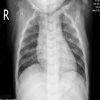

In [24]:
img = tf.keras.preprocessing.image.array_to_img(train_b_x[5000])
img

## 3. Valid

Test 를 해보기 전, 최적의 하이퍼 파라미터를 찾기 위해 Validation Set 에서 정상 이미지를 불러온다.

In [27]:
val_a_x = []

path = '/home/lifeofpy/LifeofPy/Kaggle/#3. X-ray Disease/chest_xray/val/NORMAL/*.jpeg'

for filename in glob.glob(path):
    im = Image.open(filename).convert('L')
    img = im.resize((100, 100))
    val_a_x.append(tf.keras.preprocessing.image.img_to_array(img))

정상 이미지의 라벨링을 0으로 맞춰준다.

In [28]:
a = len(val_a_x)
val_a_y = np.zeros(a)

Validation Set 에서 폐렴에 걸린 이미지를 불러온다.

In [29]:
path = '/home/lifeofpy/LifeofPy/Kaggle/#3. X-ray Disease/chest_xray/val/PNEUMONIA/*jpeg'

for filename in glob.glob(path):
    im = Image.open(filename).convert('L')
    img = im.resize((100, 100))
    val_a_x.append(tf.keras.preprocessing.image.img_to_array(img))

폐렴에 걸린 이미지의 라벨링을 1으로 맞춰준다.

In [31]:
b = len(val_a_x)
val_b_y = np.concatenate((val_a_y, np.ones(b-a)))
val_b_x = np.stack(val_a_x)

## 4. Test

Test 를 하기 위해, Test Set 에서 정상 이미지를 불러온다.

In [40]:
test_a_x = []

path = '/home/lifeofpy/LifeofPy/Kaggle/#3. X-ray Disease/chest_xray/test/NORMAL/*.jpeg'

for filename in glob.glob(path):
    im = Image.open(filename).convert('L')
    img = im.resize((100, 100))
    test_a_x.append(tf.keras.preprocessing.image.img_to_array(img))

정상 이미지의 라벨링을 0으로 맞춰준다.

In [41]:
a = len(test_a_x)
test_a_y = np.zeros(a)

Test Set 에서 폐렴에 걸린 이미지를 불러온다.

In [42]:
path = '/home/lifeofpy/LifeofPy/Kaggle/#3. X-ray Disease/chest_xray/test/PNEUMONIA/*jpeg'

for filename in glob.glob(path):
    im = Image.open(filename).convert('L')
    img = im.resize((100, 100))
    test_a_x.append(tf.keras.preprocessing.image.img_to_array(img))

폐렴에 걸린 이미지의 라벨링을 1으로 맞춰준다.

In [43]:
b = len(test_a_x)
test_b_y = np.concatenate((test_a_y, np.ones(b-a)))
test_b_x = np.stack(test_a_x)

#### 이제 각각의 data set 에 대한 크기를 출력해보자.

In [44]:
print('train shape : ',train_b_x.shape)
print('valid shape : ',val_b_x.shape)
print('test shape : ',test_b_x.shape)

train shape :  (5216, 100, 100, 1)
valid shape :  (8, 100, 100, 1)
test shape :  (624, 100, 100, 1)


Validation Set 이 월등히 작으므로, train_test_split 을 이용해 validation set 을 보강한다.

In [45]:
tx, vx, ty, vy = train_test_split(train_b_x, train_b_y)

## 5. Train Model using CNN

In [50]:
tf.random.set_seed(1234)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5) # 과적합 방지

model = tf.keras.Sequential(
[
    layers.Conv2D(filters=60, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (4, 4)),
    layers.Dropout(0.25),
    
    layers.Conv2D(40, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size = (8, 8)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy'])
mod = model.fit(tx, ty, validation_data = (vx, vy), batch_size=300, epochs=40, callbacks=[es])

Epoch 1/40
14/14 [==============================] - 1s 60ms/step - loss: 12.9414 - accuracy: 0.6002 - val_loss: 0.6364 - val_accuracy: 0.7370
Epoch 2/40
14/14 [==============================] - 1s 52ms/step - loss: 0.7870 - accuracy: 0.6748 - val_loss: 0.6868 - val_accuracy: 0.7224
Epoch 3/40
14/14 [==============================] - 1s 53ms/step - loss: 0.5859 - accuracy: 0.7380 - val_loss: 0.6756 - val_accuracy: 0.7431
Epoch 4/40
14/14 [==============================] - 1s 53ms/step - loss: 0.5492 - accuracy: 0.7505 - val_loss: 0.6475 - val_accuracy: 0.7592
Epoch 5/40
14/14 [==============================] - 1s 53ms/step - loss: 0.5354 - accuracy: 0.7474 - val_loss: 0.5886 - val_accuracy: 0.7761
Epoch 6/40
14/14 [==============================] - 1s 53ms/step - loss: 0.4588 - accuracy: 0.7906 - val_loss: 0.5440 - val_accuracy: 0.8175
Epoch 7/40
14/14 [==============================] - 1s 53ms/step - loss: 0.4195 - accuracy: 0.8149 - val_loss: 0.5255 - val_accuracy: 0.8213
Epoch 8/40
1

## 6. Visualize the Result

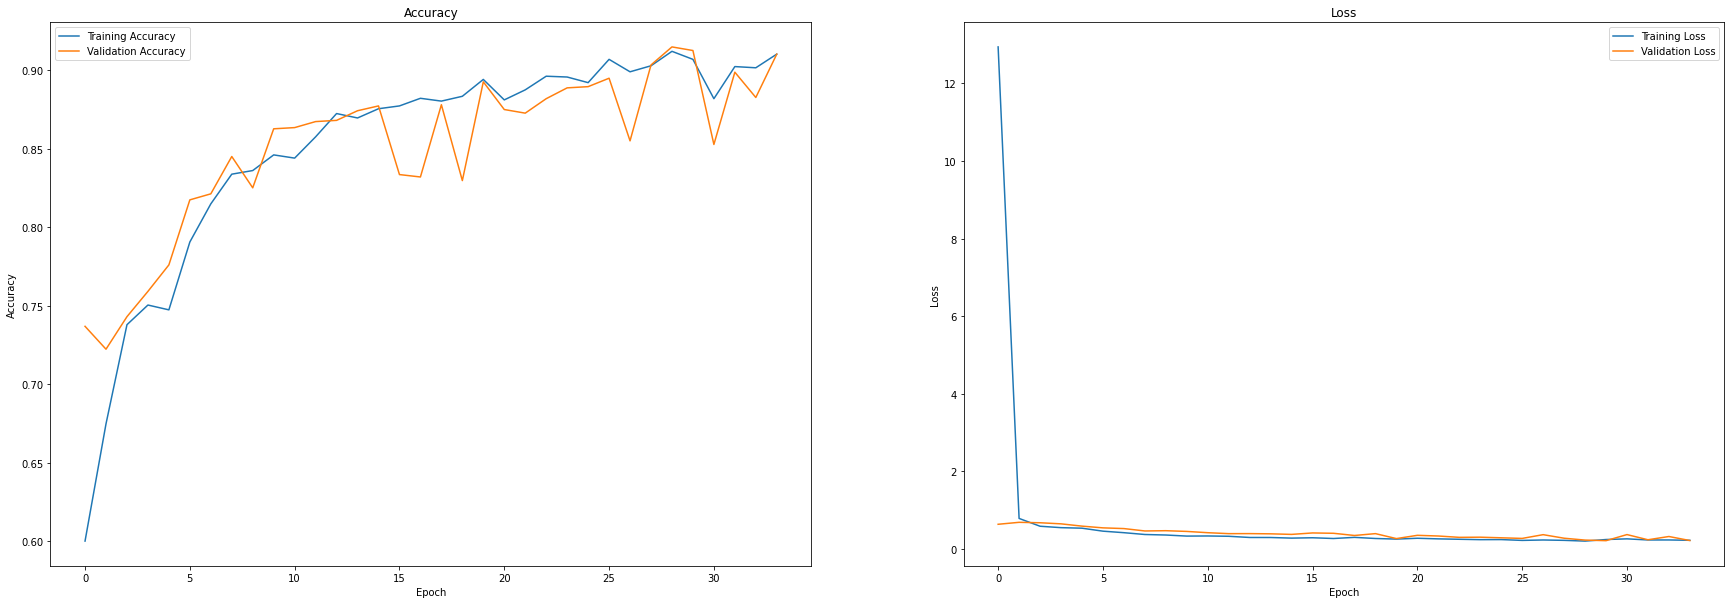

In [51]:
fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(mod.history['accuracy'])
plt.plot(mod.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss','Validation Loss'])

plt.show()

## 7. Predict by Test Data

pred = model.predict(test_b_x)

## 8. Confusion Matrix

머신러닝에서 모델이나 패턴의 분류 성능 평가에는 Precision, Recall, Accuracy 와 같은 척도가 활용된다. 이를 위해서는 2*2의 confusion matrix 를 만들어야 한다.

In [53]:
for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0
        
tf.math.confusion_matrix(test_b_y, pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[148,  86],
       [ 23, 367]], dtype=int32)>

☞ TP = 367 / FP = 86 / FN = 23 / TN = 148

## 9. Evaluation Metrics

모델 성능의 평가 지표로, Precision, Recall, Accuracy 를 모두 출력해보았다.

### 1) Precision [정밀도]

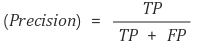

In [61]:
precision = 367 / (367 + 86)
precision

0.8101545253863135

### 2) Recall [재현율]

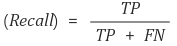

In [62]:
recall = 367 / (367 + 23)
recall

0.941025641025641

### 3) Accuracy [정확도]

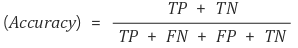

In [66]:
accuracy = (367 + 148) / (367+86+23+148)
accuracy

0.8253205128205128